## This Notebook will aim to Optimize linear Models

I have a lot of different automatic results in the previous notebook so just manually take most optimal features and reduce from there



## Start with Naive Bayes


'avg3Months_Loan', 'avg3Months_DebtCollection', 'avg6Months_Loan', 'avg6Months_Gambling', 'avg_Gambling', 'avg_Salary', 'avg3Months_Deposit', 'avg3Months_Gambling','avg_Loan', 'avg_HousingCost', 'avg3Months_CashWithdrawal' ,'avg6Months_DirectDebit', 'avg_Gaming', 'avg3Months_Gaming', 'avg_CashWithdrawal', 'avg_OtherIncome', 'avg6Months_CashWithdrawal', 'avg6Months_InstallmentPayment', 'avg_DirectDebit', 'avg6Months_HousingCost', 'avg6Months_Gaming', 'avg3Months_DirectDebit'
'count_Loan', 'trend_DebtCollection', 'sum_Loan', 'trend_Deposit', 'sum_Gambling', 'count_Gambling', 'sum_Salary', 'trend_CashWithdrawal', 'sum_DirectDebit',

'sum installmentPayments', 'trend_Loan', 'Gambling_sum9Months', 'MoneyRemittance_monthlyAvg','trend_Salary', 'MoneyRemittance_partOfSalary9Months', 'Gambling_sum12Months', 'trend_MoneyRemittance', 'Crypto_count3Months', 'trend_OtherIncome', 'trend_PassiveIncome', 'Gambling_count9Months', 'Gambling_partOfSalary3Months', 'MoneyRemittance_category',

'DebtCollection_count9Months', 'CashWithdrawal_sum3Months'

'DebtCollection_sum3Months', 'DebtCollection_sum9Months', 'InstallmentPayment_count12Months', 'DebtCollection_partOfSalary12Months', 'DebtCollection_sum12Months', 'InstallmentPayment_count9Months',



In [31]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200



FileNotFoundError: [Errno 2] No such file or directory: './Classes'

In [ ]:

################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')


In [ ]:
df

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-03-08,8205045,0,7711025523,2022-03-10,250000,1,1,0,1,...,50227.0,224.1,248.5,247.0,258.4,630444,81995,288551,519248,0
1,2022-04-07,8228347,0,9804048719,2022-04-22,400000,1,1,1,1,...,763.7,1333.3,1553.4,2678645.0,241491.0,1655157,2249127,0,0,0
2,2022-04-08,8229075,0,6501225061,2022-04-12,240000,1,1,0,1,...,85589.0,322.8,415.5,320.5,331.8,882268,279047,442904,685525,0
3,2022-04-11,8230481,0,9606236371,2022-04-13,295000,1,1,0,1,...,268.0,476.0,439.5,883993.0,100348.0,452428,627919,0,0,0
4,2022-04-15,8233936,0,8602147608,2022-06-08,270000,1,1,0,1,...,379.3,1362741.0,251386.0,547363.0,971946.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,2023-04-28,8660675,0,8902289209,2023-05-31,271000,1,1,1,0,...,195.3,381102.0,84024.0,274075.0,312523.0,0,0,0,0,0
3489,2023-04-28,8660675,0,8903213695,2023-05-31,271000,0,2,1,0,...,121.2,348937.0,91087.0,215240.0,265065.0,0,0,0,0,0
3490,2023-04-28,8660600,0,8007075586,2023-05-08,350000,1,1,1,0,...,40754.0,165.3,135.9,130.5,145.1,509094,147353,245526,367844,0
3491,2023-04-28,8660600,0,8203014934,2023-05-08,350000,0,2,1,0,...,38839.0,96.0,76.7,72.3,92.7,487593,113811,198074,353883,0


In [ ]:
# pd.set_option('display.max_columns', None)

# git add .

# git commit -m "Finalised API Loop"

#  git status

#  git push origin Andreas

In [ ]:
df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge'])

base = df.drop(columns=['HasCoapp'])




Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Optimal number of features: 178
Best features: ['avg_CashWithdrawal' 'avg_DebtCollection' 'avg_Deposit' 'avg_Gambling'
 'avg_Gaming' 'avg_HousingCost' 'avg_InstallmentPayment' 'avg_Loan'
 'avg_MobilePayment' 'avg_OtherIncome' 'avg_Salary'
 'avg3Months_CashWithdrawal' 'avg3Months_DebtCollection'
 'avg3Months_Deposit' 'avg3Months_DirectDebit' 'avg3Months_Gambling'
 'avg3Months_Gaming' 'avg3Months_HousingCost'
 'avg3Months_InstallmentPayment' 'avg3Months_Loan'
 'avg3Months_MobilePayment' 'avg3Months_OtherIncome' 'avg3Months_Salary'
 'avg6Months_CashWithdrawal' 'avg6Months_DebtCollection'
 'avg6Months_Deposit' 'avg6Months_DirectDebit' 'avg6Months_Gambling'
 'avg6Months_Gaming' 'avg6Months_HousingCost'
 'avg6Months_InstallmentPayment' 'avg6Months_Loan'
 'avg6Months_MobilePayment' 'avg6Months_OtherIncome' 'avg6Months_Salary'
 'count_CashWithdrawal' 'count_DebtCollection' 'count_Deposit'
 'count_Gambling' 'count_Gaming' 'count

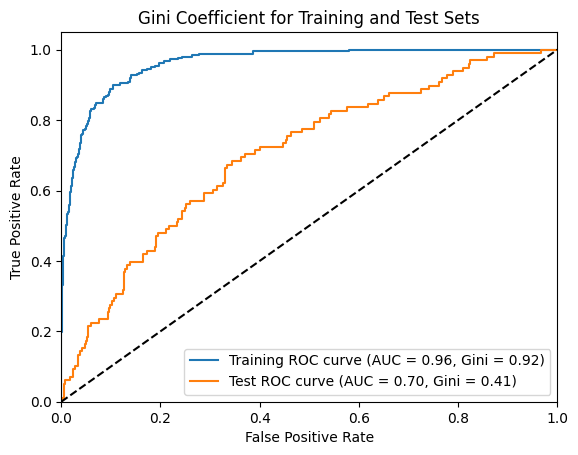

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(base)

(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)

# Define the Random Forest classifier
rf = RandomForestClassifier(
    criterion='gini', 
    random_state=42,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=6,
    n_estimators=122
)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(base.iloc[:, 1:].columns)[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba.reshape(-1, 1))
    gini_test = gini_scorer(y_test, y_test_pred_proba.reshape(-1, 1))
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

# Transform the test set using RFECV
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and test sets

plot_gini(rf, X_optimal, Ytrain_resampled, X_test_optimal, Ytest, 'Gini Coefficient for Training and Test Sets')

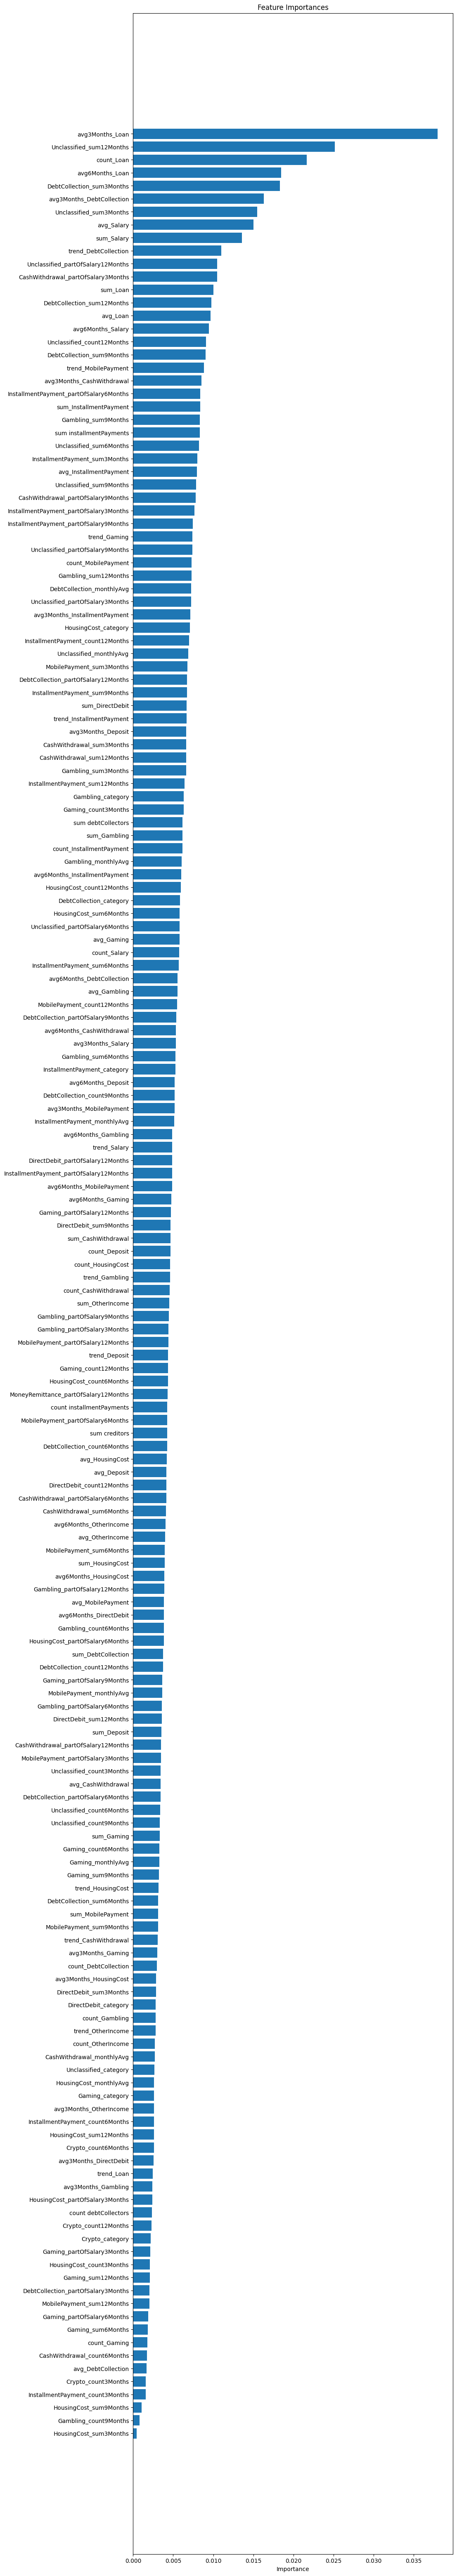

In [ ]:

# Plotting feature importances in ascending order
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Sort feature importances in ascending order
    sorted_features = feature_names[indices]

    plt.figure(figsize=(10, 80))
    plt.title("Feature Importances")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), sorted_features)
    plt.xlabel("Importance")
    plt.show()

    return  sorted_features

# Plot feature importances
sorted_features = plot_feature_importances(rf, optimal_features)

178
Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64


Optimal number of features: 144
Best features: ['HousingCost_sum3Months' 'Crypto_count3Months' 'avg_DebtCollection'
 'CashWithdrawal_count6Months' 'count_Gaming' 'MobilePayment_sum12Months'
 'Gaming_sum12Months' 'HousingCost_count3Months'
 'Gaming_partOfSalary3Months' 'Crypto_count12Months' 'avg3Months_Gambling'
 'trend_Loan' 'avg3Months_DirectDebit' 'Crypto_count6Months'
 'InstallmentPayment_count6Months' 'avg3Months_OtherIncome'
 'Gaming_category' 'CashWithdrawal_monthlyAvg' 'count_Gambling'
 'DirectDebit_sum3Months' 'avg3Months_Gaming' 'MobilePayment_sum9Months'
 'DebtCollection_sum6Months' 'Gaming_sum9Months' 'Gaming_monthlyAvg'
 'Gaming_count6Months' 'sum_Gaming' 'Unclassified_count6Months'
 'DebtCollection_partOfSalary6Months' 'MobilePayment_partOfSalary3Months'
 'CashWithdrawal_partOfSalary12Months' 'sum_Deposit'
 'DirectDebit_sum12Months' 'Gambling_partOfSalary6Months'
 'MobilePayment_monthlyAvg' 'sum_DebtCollection'
 'HousingCost_partOfSalary6Months' 'Gambling_count6Months'
 '

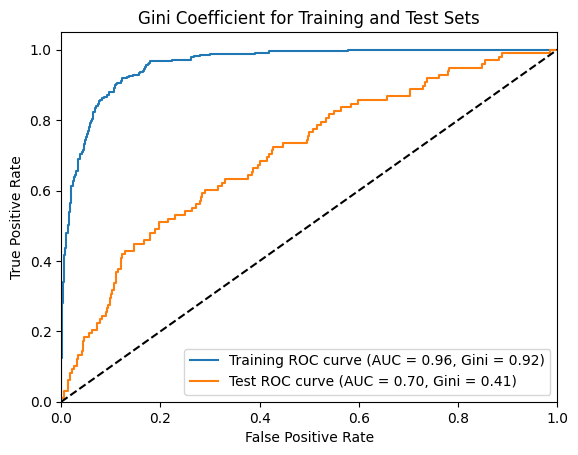

In [ ]:
forforsta = base[['Ever90']+list(sorted_features)]

print(len(sorted_features))


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)

# Define the Random Forest classifier
rf = RandomForestClassifier(
    criterion='gini', 
    random_state=42,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=6,
    n_estimators=122
)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(forforsta.iloc[:, 1:].columns)[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba.reshape(-1, 1))
    gini_test = gini_scorer(y_test, y_test_pred_proba.reshape(-1, 1))
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

# Transform the test set using RFECV
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and test sets

plot_gini(rf, X_optimal, Ytrain_resampled, X_test_optimal, Ytest, 'Gini Coefficient for Training and Test Sets')

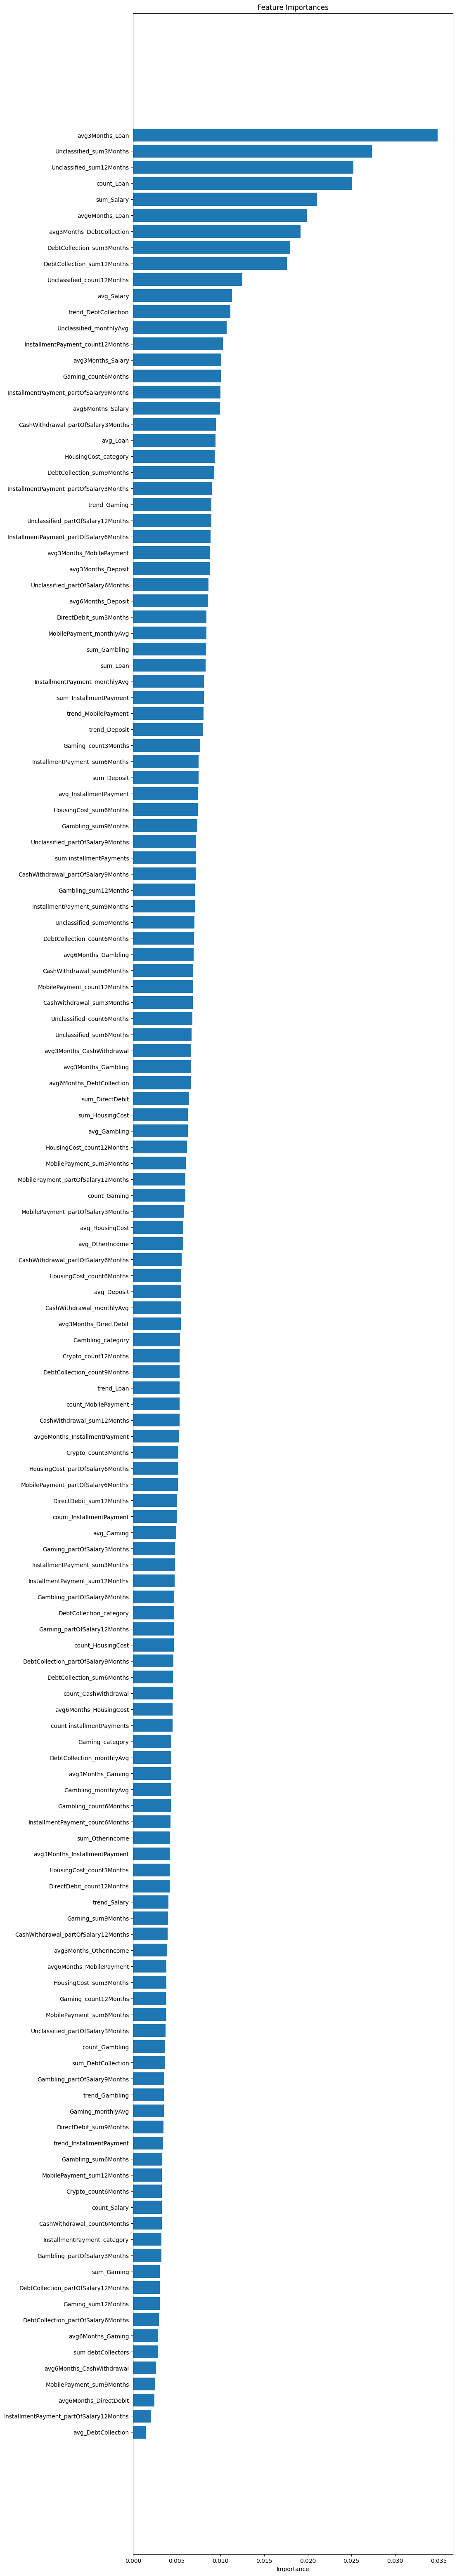

In [ ]:

# Plotting feature importances in ascending order
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Sort feature importances in ascending order
    sorted_features = feature_names[indices]

    plt.figure(figsize=(10, 80))
    plt.title("Feature Importances")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), sorted_features)
    plt.xlabel("Importance")
    plt.show()

    return  sorted_features

# Plot feature importances
sorted_features = plot_feature_importances(rf, optimal_features)

Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Optimal number of features: 103
Best features: ['Gambling_monthlyAvg' 'avg3Months_Gaming' 'DebtCollection_monthlyAvg'
 'Gaming_category' 'count installmentPayments' 'avg6Months_HousingCost'
 'count_CashWithdrawal' 'DebtCollection_sum6Months'
 'DebtCollection_partOfSalary9Months' 'count_HousingCost'
 'Gaming_partOfSalary12Months' 'DebtCollection_category'
 'Gambling_partOfSalary6Months' 'InstallmentPayment_sum12Months'
 'InstallmentPayment_sum3Months' 'Gaming_partOfSalary3Months' 'avg_Gaming'
 'count_InstallmentPayment' 'DirectDebit_sum12Months'
 'MobilePayment_partOfSalary6Months' 'HousingCost_partOfSalary6Months'
 'Crypto_count3Months' 'avg6Months_InstallmentPayment'
 'CashWithdrawal_sum12Months' 'count_MobilePayment' 'trend_Loan'
 'DebtCollection_count9Months' 'Gambling_category'
 'avg3Months_DirectDebit' 'CashWithdrawal_monthlyAvg' 'avg_Deposit'
 'HousingCost_count6Months' 'CashWithdrawal_partOfSalary6Months'
 'avg_O

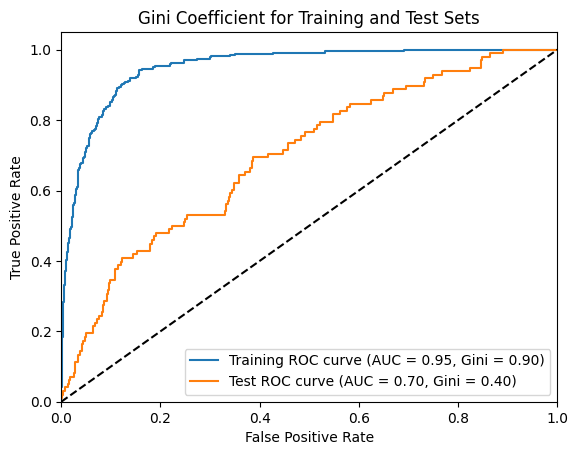

In [ ]:
forforsta = base[['Ever90']+list(sorted_features[40:])]

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)

# Define the Random Forest classifier
rf = RandomForestClassifier(
    criterion='gini', 
    random_state=42,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=6,
    n_estimators=122
)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(forforsta.iloc[:, 1:].columns)[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba.reshape(-1, 1))
    gini_test = gini_scorer(y_test, y_test_pred_proba.reshape(-1, 1))
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

# Transform the test set using RFECV
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and test sets

plot_gini(rf, X_optimal, Ytrain_resampled, X_test_optimal, Ytest, 'Gini Coefficient for Training and Test Sets')

Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Optimal number of features: 89
Best features: ['Gaming_partOfSalary12Months' 'DebtCollection_category'
 'Gambling_partOfSalary6Months' 'InstallmentPayment_sum12Months'
 'InstallmentPayment_sum3Months' 'Gaming_partOfSalary3Months' 'avg_Gaming'
 'count_InstallmentPayment' 'DirectDebit_sum12Months'
 'MobilePayment_partOfSalary6Months' 'HousingCost_partOfSalary6Months'
 'avg6Months_InstallmentPayment' 'CashWithdrawal_sum12Months'
 'count_MobilePayment' 'Crypto_count12Months' 'Gambling_category'
 'CashWithdrawal_monthlyAvg' 'avg_Deposit' 'HousingCost_count6Months'
 'CashWithdrawal_partOfSalary6Months' 'avg_OtherIncome' 'avg_HousingCost'
 'MobilePayment_partOfSalary3Months' 'count_Gaming'
 'MobilePayment_partOfSalary12Months' 'MobilePayment_sum3Months'
 'HousingCost_count12Months' 'avg_Gambling' 'sum_HousingCost'
 'avg6Months_DebtCollection' 'avg3Months_Gambling'
 'avg3Months_CashWithdrawal' 'Unclassified_sum6Months'
 'Unclas

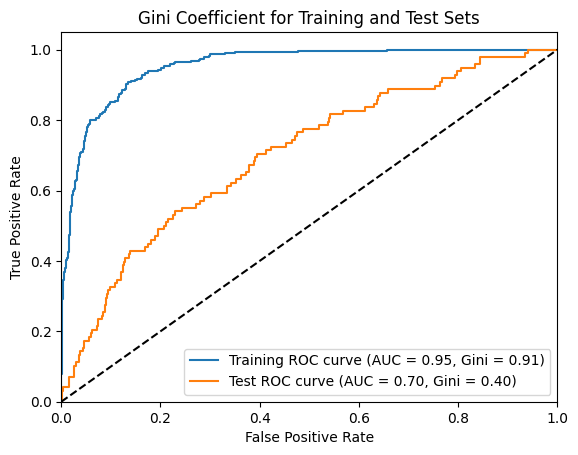

In [ ]:
forforsta = base[['Ever90']+list(sorted_features[50:])]

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)

# Define the Random Forest classifier
rf = RandomForestClassifier(
    criterion='gini', 
    random_state=42,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=6,
    n_estimators=122
)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(forforsta.iloc[:, 1:].columns)[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba.reshape(-1, 1))
    gini_test = gini_scorer(y_test, y_test_pred_proba.reshape(-1, 1))
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

# Transform the test set using RFECV
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and test sets

plot_gini(rf, X_optimal, Ytrain_resampled, X_test_optimal, Ytest, 'Gini Coefficient for Training and Test Sets')

Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Optimal number of features: 54
Best features: ['MobilePayment_count12Months' 'CashWithdrawal_sum6Months'
 'avg6Months_Gambling' 'DebtCollection_count6Months'
 'Unclassified_sum9Months' 'InstallmentPayment_sum9Months'
 'Gambling_sum12Months' 'CashWithdrawal_partOfSalary9Months'
 'sum installmentPayments' 'Unclassified_partOfSalary9Months'
 'Gambling_sum9Months' 'HousingCost_sum6Months' 'avg_InstallmentPayment'
 'sum_Deposit' 'InstallmentPayment_sum6Months' 'Gaming_count3Months'
 'trend_Deposit' 'trend_MobilePayment' 'sum_InstallmentPayment'
 'InstallmentPayment_monthlyAvg' 'sum_Loan' 'sum_Gambling'
 'MobilePayment_monthlyAvg' 'DirectDebit_sum3Months' 'avg6Months_Deposit'
 'Unclassified_partOfSalary6Months' 'avg3Months_Deposit'
 'avg3Months_MobilePayment' 'InstallmentPayment_partOfSalary6Months'
 'Unclassified_partOfSalary12Months' 'trend_Gaming'
 'InstallmentPayment_partOfSalary3Months' 'DebtCollection_sum9Months'
 'Hous

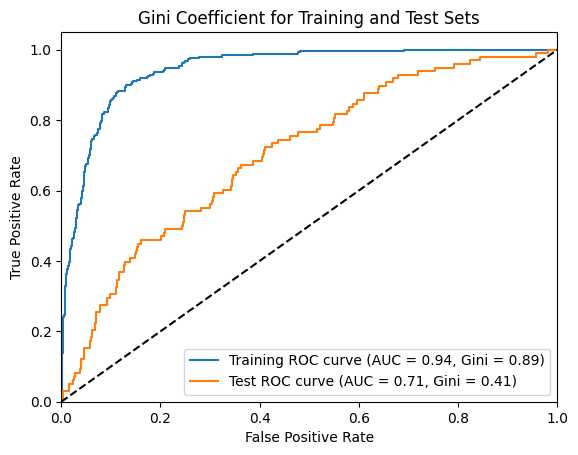

In [ ]:
forforsta = base[['Ever90']+list(sorted_features[90:])]

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)

# Define the Random Forest classifier
rf = RandomForestClassifier(
    criterion='gini', 
    random_state=42,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=6,
    n_estimators=122
)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(forforsta.iloc[:, 1:].columns)[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_test, y_test, title ,ifplot = True):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba.reshape(-1, 1))
    gini_test = gini_scorer(y_test, y_test_pred_proba.reshape(-1, 1))
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    if ifplot == True:

        plt.figure()
        plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
        plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")

        plt.show()
    
    else:
        return gini_test

# Transform the test set using RFECV
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and test sets

plot_gini(rf, X_optimal, Ytrain_resampled, X_test_optimal, Ytest, 'Gini Coefficient for Training and Test Sets', True)

In [ ]:
forforsta = base[['Ever90']+list(sorted_features[90:])]

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)

# Define the Random Forest classifier
rf = RandomForestClassifier(
    criterion='gini', 
    random_state=42,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=6,
    n_estimators=122
)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(forforsta.iloc[:, 1:].columns)[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())




# Transform the test set using RFECV
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and test sets

plot_gini(rf, X_optimal, Ytrain_resampled, X_test_optimal, Ytest, 'Gini Coefficient for Training and Test Sets', False)

## Plot the GINI based on input features in RF

In [ ]:
FeaturesRun_GINISCORE = []
NR_Features = [] 
NR_OPTIMAL_FEATURES = []



start  = 60

for nr in range(len(sorted_features[start:])-1):


    forforsta = base[['Ever90']+list(sorted_features[start+nr:])]

        
    # Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
    preprocessor = DataPreprocessor(forforsta)

    (Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

    # Custom Gini coefficient scorer
    def gini_scorer(y_true, y_pred):
        auc = roc_auc_score(y_true, y_pred)
        return 2 * auc - 1

    # Ensure the custom scorer is correctly created
    gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)

    # Define the Random Forest classifier
    rf = RandomForestClassifier(
        criterion='gini', 
        random_state=42,
        max_depth=5,
        min_samples_leaf=2,
        min_samples_split=6,
        n_estimators=122
    )

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=420)
    Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

    # Define the RFECV object for recursive feature elimination with cross-validation
    rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

    # Perform RFECV on the resampled data
    rfecv.fit(Xtrain_resampled, Ytrain_resampled)

    # Output the results
    optimal_features = np.array(forforsta.iloc[:, 1:].columns)[rfecv.support_]
    print("Optimal number of features: %d" % rfecv.n_features_)
    print("Best features: %s" % optimal_features)

    # Transform the dataset to the optimal feature set
    X_optimal = rfecv.transform(Xtrain_resampled)

    # Retrain the model with the optimal feature set
    rf.fit(X_optimal, Ytrain_resampled)

    # Evaluate the final model
    final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
    print("Final model Gini coefficient: %0.4f" % final_score.mean())




    # Transform the test set using RFECV
    X_test_optimal = rfecv.transform(Xtest)

    # Plot for both the training and test sets

    FeaturesRun_GINISCORE.append(plot_gini(rf, X_optimal, Ytrain_resampled, X_test_optimal, Ytest, 'Gini Coefficient for Training and Test Sets', False))
    NR_Features.append(nr) 
    NR_OPTIMAL_FEATURES.append(len(optimal_features))








Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Optimal number of features: 84
Best features: ['HousingCost_partOfSalary6Months' 'Crypto_count3Months'
 'avg6Months_InstallmentPayment' 'CashWithdrawal_sum12Months'
 'count_MobilePayment' 'trend_Loan' 'DebtCollection_count9Months'
 'Crypto_count12Months' 'Gambling_category' 'avg3Months_DirectDebit'
 'CashWithdrawal_monthlyAvg' 'avg_Deposit' 'HousingCost_count6Months'
 'CashWithdrawal_partOfSalary6Months' 'avg_OtherIncome' 'avg_HousingCost'
 'MobilePayment_partOfSalary3Months' 'count_Gaming'
 'MobilePayment_partOfSalary12Months' 'MobilePayment_sum3Months'
 'HousingCost_count12Months' 'avg_Gambling' 'sum_HousingCost'
 'sum_DirectDebit' 'avg6Months_DebtCollection' 'avg3Months_Gambling'
 'avg3Months_CashWithdrawal' 'Unclassified_sum6Months'
 'Unclassified_count6Months' 'CashWithdrawal_sum3Months'
 'MobilePayment_count12Months' 'CashWithdrawal_sum6Months'
 'avg6Months_Gambling' 'DebtCollection_count6Months'
 'Unclassified_su

KeyboardInterrupt: 

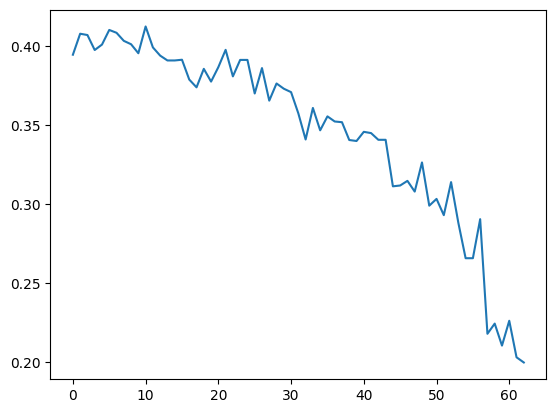

In [ ]:
plt.plot(FeaturesRun_GINISCORE)